In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import reduce
import pyspark.sql.functions as F  
from pyspark.sql.functions import col  
from holidays import WEEKEND, HolidayBase
from dateutil.easter import easter
from dateutil.relativedelta import relativedelta as rd
from dateutil.easter import easter
from pyspark.sql.functions import col  
import fbprophet
import warnings
from plotnine import *
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from pyspark import SparkContext
from pyspark.sql import SQLContext
os.environ['JAVA_HOME'] = "/Library/Java/JavaVirtualMachines/jdk1.8.0_202.jdk/Contents/Home"
sc = SparkContext("local", "SparkApp")
spark = SQLContext(sc)

In [2]:
#read csv files and union them together into a dataframe

def get_df(c):
    df = spark.read.format("csv").option("header","True")\
    .load("covid-19-excess-deaths-tracker-master/output-data/historical-deaths/"+c+"_weekly_deaths.csv")\
    .orderBy("start_date")
    return df

alldf = {
"uk":  get_df("britain").filter("region='Britain'").select("start_date","total_deaths","covid_deaths"),
"ger": get_df("germany").select("start_date","total_deaths","covid_deaths"),
"fr":  get_df("france").filter("region='France'").select("start_date","total_deaths","covid_deaths"),
"us":  get_df("united_states").groupBy("start_date").agg(F.sum(col("total_deaths")).alias("total_deaths"),F.sum(col("covid_deaths")).alias("covid_deaths")),
"it":  get_df("italy").filter("region='Italy'").groupBy("start_date").agg(F.sum(col("total_deaths")).alias("total_deaths"),F.sum(col("covid_deaths")).alias("covid_deaths")),
"nl":  get_df("netherlands").filter("region='Netherlands'").groupBy("start_date").agg(F.sum(col("total_deaths")).alias("total_deaths"),F.sum(col("covid_deaths")).alias("covid_deaths"))
}

all_countries_df = reduce(lambda x,y: x.union(y),[v.withColumn("country",F.lit(k)) for  (k,v)  in alldf.items()])\
    .select(col("country"),col("start_date"),col("total_deaths").cast("double"),col("covid_deaths").cast("double"))\

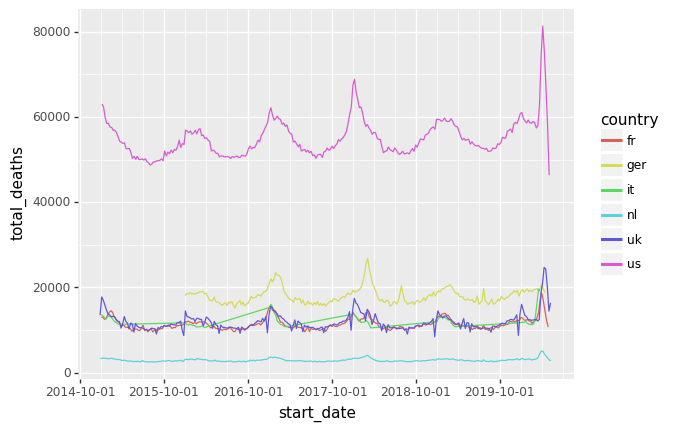

<ggplot: (8779819135933)>

In [3]:
all_countries = all_countries_df.toPandas()
all_countries["start_date"]=pd.to_datetime(all_countries["start_date"])
ggplot(all_countries, aes(x='start_date',y="total_deaths",color="country"))+ geom_line()\
+scale_x_date(breaks= "12 month", date_minor_breaks = "3 months")\
+scale_y_continuous()

In [4]:
def get_mod():
    m = fbprophet.Prophet(daily_seasonality=False,weekly_seasonality=False,mcmc_samples=1000\
                          ,growth="linear",n_changepoints=0,seasonality_prior_scale=1.0)
    m.add_seasonality(name="quarterly",period=30*4,fourier_order=5)
    m.add_seasonality(name="yearly",period=365.25,fourier_order=5)
    return m 

def get_deltas(df):
    missing = df.filter("start_date>'2020-02-01'").count()
    dfp = df.withColumn("ds",col("start_date")).withColumn("y",col("total_deaths")).toPandas()
    dft = df.withColumn("ds",col("start_date")).withColumn("y",col("total_deaths")).filter("ds<'2020-01-01'").toPandas()
    m = get_mod()
    m.fit(dft)
    dfp = m.setup_dataframe(dfp)
    yhat = m.sample_posterior_predictive(dfp)["yhat"]
    x = np.sum((np.array(dfp["y"]).reshape((-1,1))-yhat)[-missing:,:],axis=0)
    return x

In [5]:
all_deltas = {k:get_deltas(alldf[k]) for (k,v) in alldf.items()}

totaldeath = all_countries_df.groupBy("country").agg(F.sum("covid_deaths")).toPandas()

totaldeath = {row[1][0]:row[1][1] for row in totaldeath.iterrows()}

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.


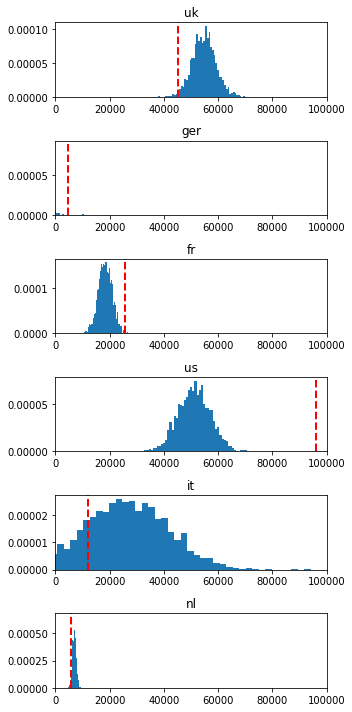

In [6]:
f,a = plt.subplots(6,1, figsize=(5,10))
a = a.ravel()
for country,ax in zip(all_deltas.keys(),a):
    x = all_deltas[country]
    ax.set_title(country)
    ax.hist(x, 50,density=True,histtype="stepfilled")
    ax.set_xlim(0,100*1000)
    ax.axvline(x=totaldeath[country], color='r', linestyle='dashed', linewidth=2)

plt.tight_layout()

display(ax)

In [7]:
def get_forecast(df):
    dfp = df.withColumn("ds",col("start_date")).withColumn("y",col("total_deaths")).toPandas()
    dft = df.withColumn("ds",col("start_date")).withColumn("y",col("total_deaths")).filter("ds<'2020-01-01'").toPandas()
    m = get_mod()
    m.fit(dft)
    yhat = m.sample_posterior_predictive(m.setup_dataframe(dfp))["yhat"]

    def extract(i):
        df = pd.DataFrame(data=yhat[:,i])
        df["ds"] = dfp["ds"]
        df["bid"] = [i for x in range(yhat.shape[0])]
        df.columns = ["pred","ds","bid"]
        return df
   
    df =extract(0)
    df.columns = ["pred","ds","bid"]
    
    for d in range(1,yhat.shape[1]):
        df  = pd.concat([df,extract(d)], ignore_index=True)
 
    return spark.createDataFrame(df), m.params

In [8]:
def country_check(c):
    df = (get_forecast(alldf[c])[0]
    .join(alldf[c].withColumn("ds",col("start_date"))
    .withColumn("actual",col("total_deaths")),["ds"],"left")
    .filter("ds>'2017-01-01'")   
    .groupBy("start_date").agg(F.avg(col("pred")).alias("pred"),F.avg(col("actual")).alias("actual"))
    ).toPandas()
    df["start_date"]=pd.to_datetime(df["start_date"])
    return df

In [ ]:
df = country_check("ger")

ggplot(df, aes('start_date'))+ geom_line(aes(y="pred",group=1),color="red")\
+ geom_line(aes(y="actual",group=1),color="blue")+scale_x_date(breaks= "2 month", date_minor_breaks = "3 months")\
+ theme(axis_text_x  = element_text(angle = 90, hjust = 1))

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.


In [ ]:
df = country_check("us")

ggplot(df, aes('start_date'))+ geom_line(aes(y="pred",group=1),color="red")\
+ geom_line(aes(y="actual",group=1),color="blue")+scale_x_date(breaks= "2 month", date_minor_breaks = "3 months")\
+ theme(axis_text_x  = element_text(angle = 90, hjust = 1))

In [ ]:
df = country_check("ger")

ggplot(df, aes('start_date'))+ geom_line(aes(y="pred",group=1),color="red")\
+ geom_line(aes(y="actual",group=1),color="blue")+scale_x_date(breaks= "2 month", date_minor_breaks = "3 months")\
+ theme(axis_text_x  = element_text(angle = 90, hjust = 1))

In [ ]:
df = country_check("it")

ggplot(df, aes('start_date'))+ geom_line(aes(y="pred",group=1),color="red")\
+ geom_line(aes(y="actual",group=1),color="blue")+scale_x_date(breaks= "2 month", date_minor_breaks = "3 months")\
+ theme(axis_text_x  = element_text(angle = 90, hjust = 1))